In [1]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load Data 

In [2]:
os.chdir('..')

In [3]:
df = pd.read_parquet(os.path.join(os.getcwd(), 'data','modelData', 'modelData.parquet'))

# PCA

In [4]:
binNumber = 32
df = df[df['BIN'] == binNumber]
df = df.drop(columns = 'BIN')
df.reset_index(drop=True,inplace = True)

In [5]:
groupMasks = []

for i in range(1,9):
    groupMasks.append(df[df['MASK'] == i])

In [6]:
xMasks = []
labelMasks = []

for i in np.arange(8):
    xMasks.append(groupMasks[i].drop(columns=['ID','MASK','SEVERE']).reset_index(drop = True))
    labelMasks.append(groupMasks[i][['ID','MASK','SEVERE']].reset_index(drop = True))

In [7]:
x_Masks_normalized = []

for i in np.arange(8):
    x_Masks_normalized.append(StandardScaler().fit_transform(xMasks[i]))

## 2D visualization

In [8]:
pca = PCA()

explainedVariance = []

principalComponents = []

for i in np.arange(8):
    principalComponents.append(pca.fit_transform(x_Masks_normalized[i]))
    explainedVariance.append(pca.explained_variance_ratio_)

In [9]:
finalDf = []
principalDf = []

for i in np.arange(8):
    principalDf.append(pd.DataFrame(data = principalComponents[i][:,:2], 
                        columns = ['principal component 1', 'principal component 2']))
    finalDf.append(pd.concat([principalDf[i], labelMasks[i]['SEVERE']], axis = 1))

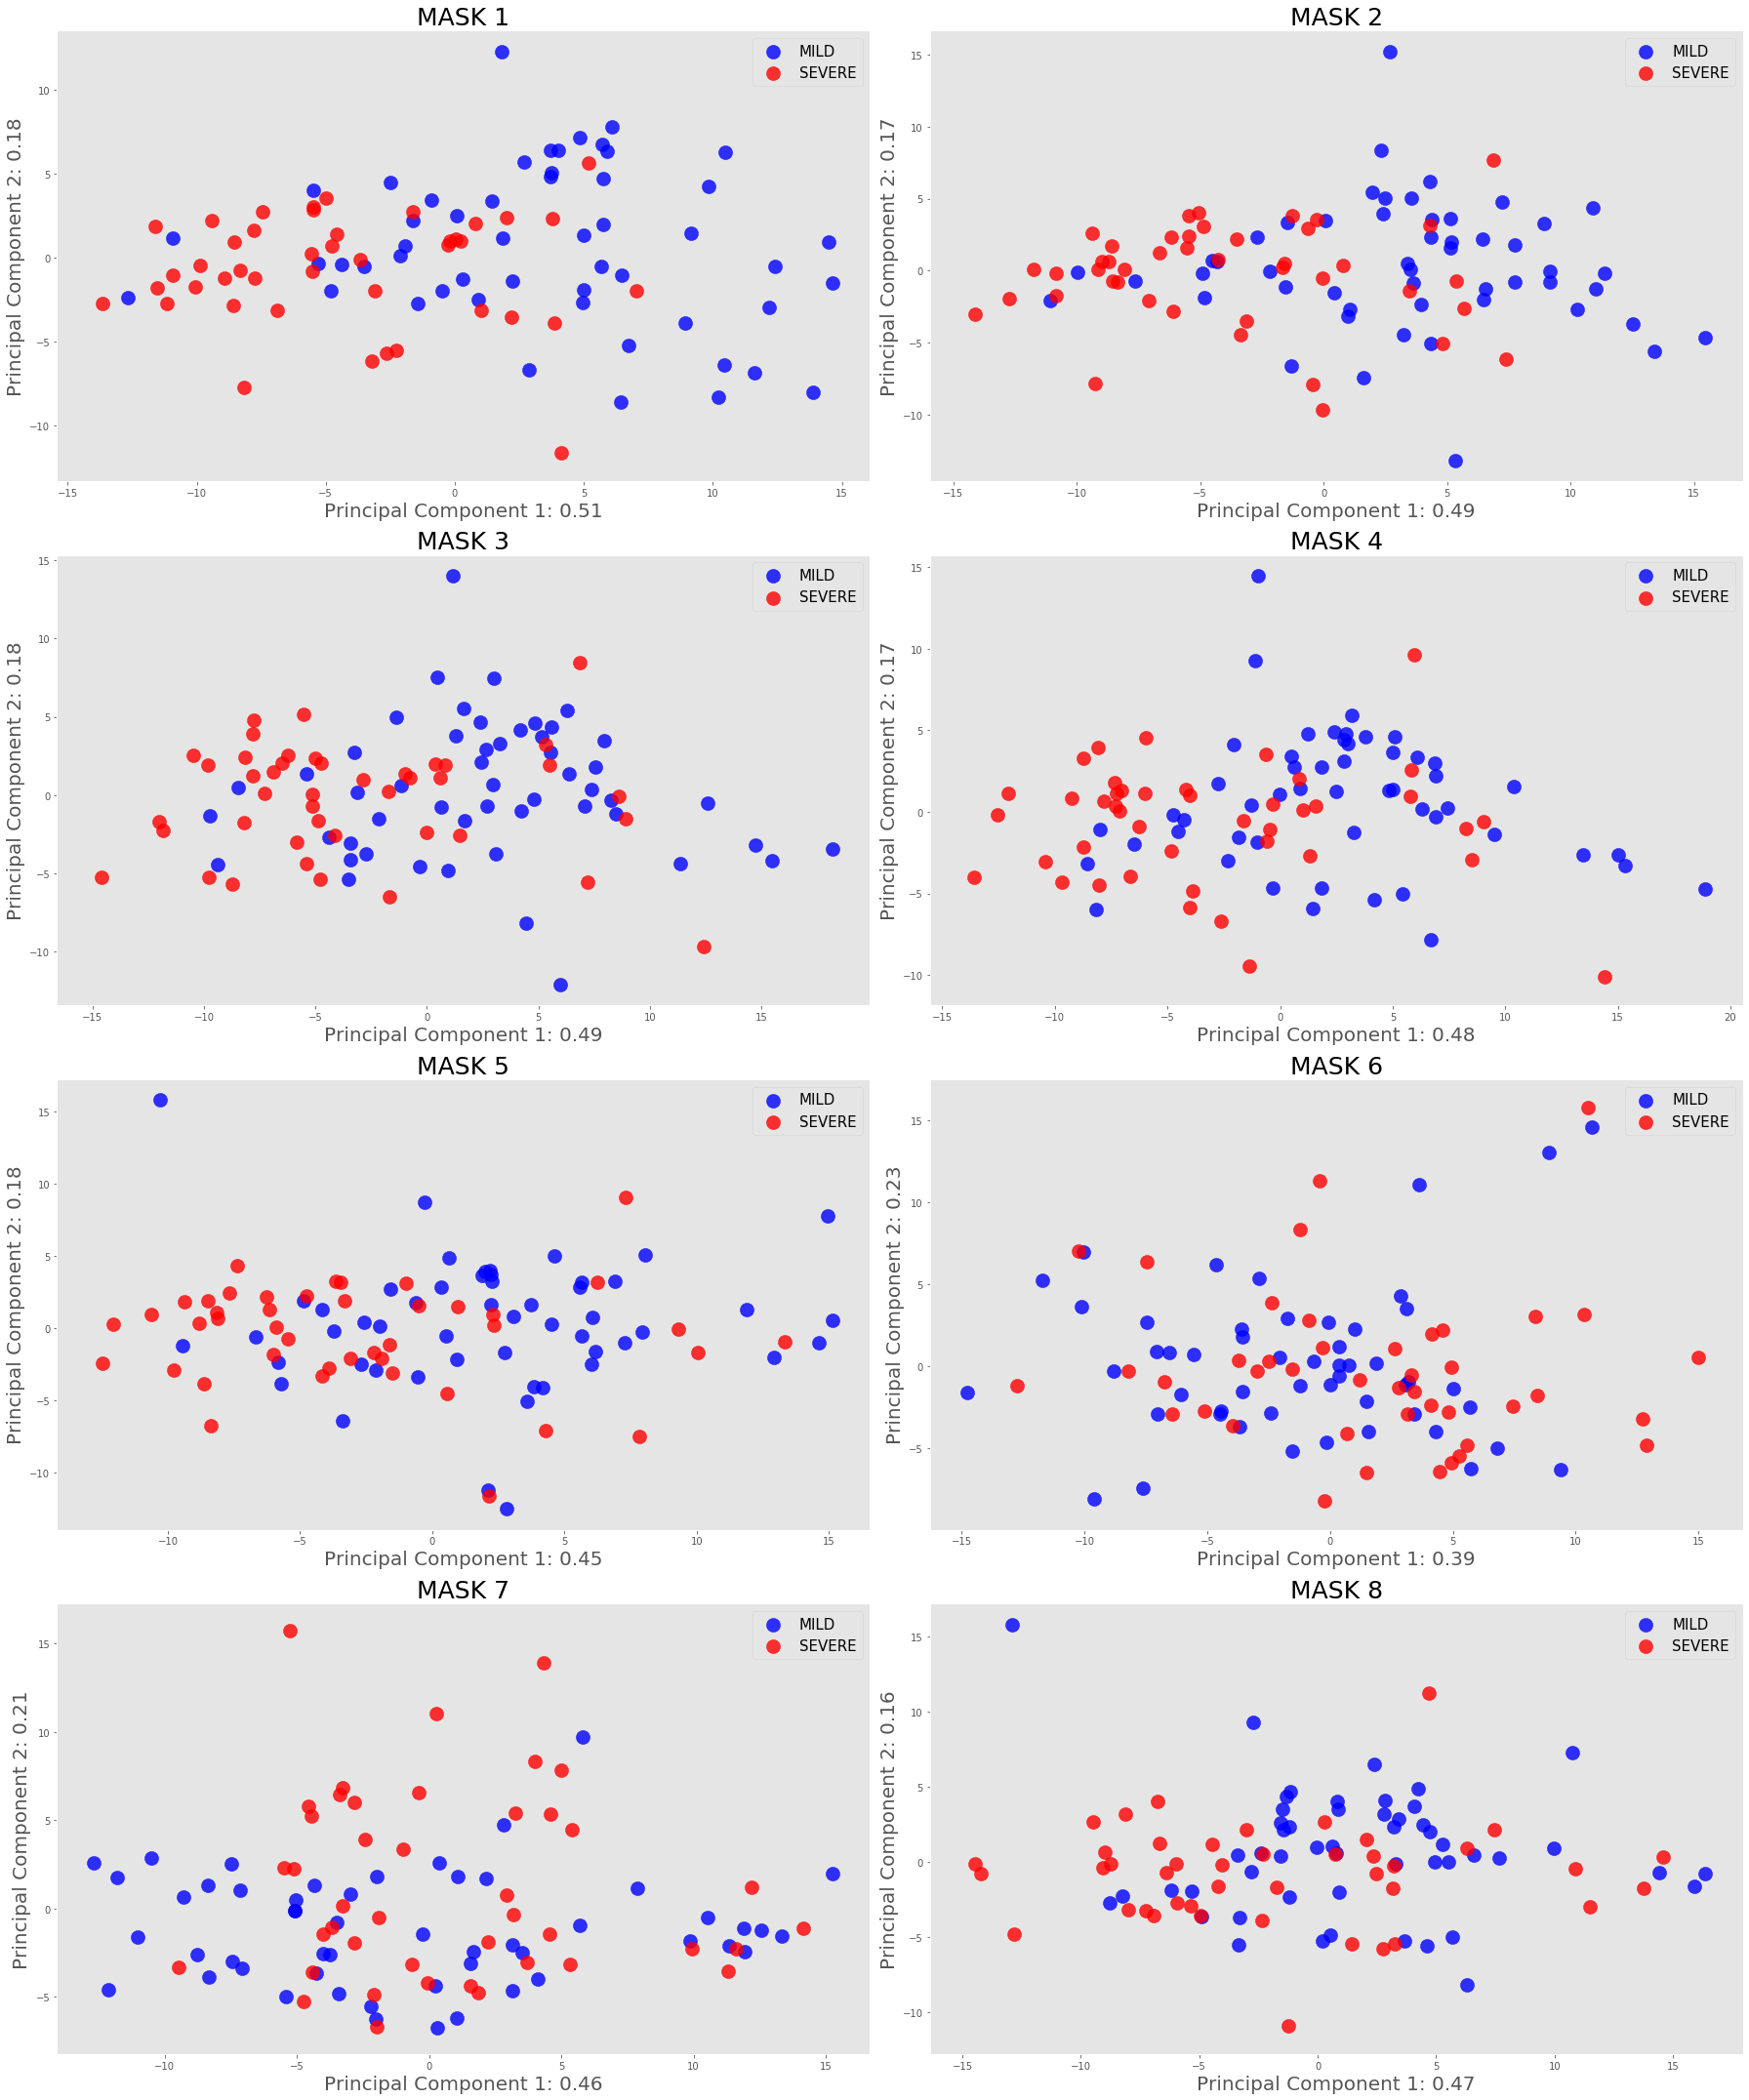

In [19]:
fig = plt.figure(figsize = (25,30))

for i in np.arange(8):
    ax = fig.add_subplot(4,2,i+1) 
    ax.set_xlabel('Principal Component 1: {0:.2f}'.format(explainedVariance[i][0]), fontsize = 20)
    ax.set_ylabel('Principal Component 2: {0:.2f}'.format(explainedVariance[i][1]), fontsize = 20)
    ax.set_title('MASK {}'.format(i+1), fontsize = 25)
    targets = [0,1]
    colors = ['b', 'r']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[i]['SEVERE'] == target
        ax.scatter(finalDf[i].loc[indicesToKeep, 'principal component 1']
                   , finalDf[i].loc[indicesToKeep, 'principal component 2']
                   , c = color
                   , s = 200,
                   alpha = 0.8 )
    ax.legend(['MILD', 'SEVERE'],fontsize = 15)
    ax.grid()
    
plt.tight_layout()
plt.ticklabel_format()
plt.savefig(os.path.join(os.getcwd(), 'figures', 'pca', 'pcaMasks.png'), format ='png')
plt.show()


## Accumulative Plot

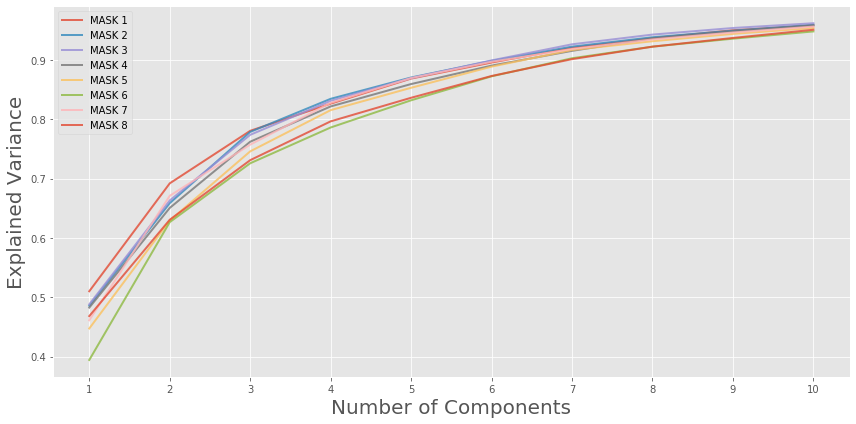

In [27]:
fig = plt.figure(figsize = (12,6))

n_components = 10
for maskNumber, i in enumerate(explainedVariance):
    plt.plot(range(len(i[:n_components])) , np.cumsum(i[:n_components]), label = f'MASK {maskNumber+1}', lw = 2, alpha = 0.8)

plt.xlabel('Number of Components', fontsize = 20)
plt.ylabel('Explained Variance', fontsize = 20)
plt.xticks(range(0, n_components),range(1,n_components+1))
plt.legend()

plt.tight_layout()
plt.ticklabel_format()
plt.savefig(os.path.join(os.getcwd(), 'figures', 'pca', 'pcaAccumulative.png'), format ='png')
plt.show()